# Imports and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

import time

In [2]:
device = 'cpu'

In [3]:
X_train = np.load('X-IIoT-pre-processed/x_train.npy')
y_train = np.load('X-IIoT-pre-processed/y_train.npy')
X_val = np.load('X-IIoT-pre-processed/X_val.npy')
y_val = np.load('X-IIoT-pre-processed/y_val.npy')
X_test = np.load('X-IIoT-pre-processed/X_test.npy')
y_test = np.load('X-IIoT-pre-processed/y_test.npy')

# Deep Neural Network

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [28]:
class DNNMulticlass(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(58, 200) # 58 features => len(X_train[0])
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, 200)
        self.layer4 = nn.Linear(200, 200)
        self.out_layer = nn.Linear(200, 19) # 19 classifications =>  np.unique(y_train)

    def forward(self, x):
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        x = F.leaky_relu(self.layer3(x))
        x = F.leaky_relu(self.layer4(x))
        x = self.out_layer(x) 
        return x

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)

y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=100)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=100)

In [29]:
# Training

start_time = time.time()

model_dnn = DNNMulticlass().to(device)
early_stopping = EarlyStopping(patience=10, delta=0.001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dnn.parameters(), lr=0.001)

training_losses = []
validation_losses = []

epochs = 100
for epoch in range(epochs): # Epochs/steps
    model_dnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Feed forward + backpropogate
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_dnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


print('Finished Training')

training_time = time.time() - start_time
print(f"Training time: {training_time}")

Epoch [1/100], Training Loss: 0.1778, Validation Loss: 0.1099
Epoch [2/100], Training Loss: 0.0934, Validation Loss: 0.0871
Epoch [3/100], Training Loss: 0.0793, Validation Loss: 0.0819
Epoch [4/100], Training Loss: 0.0712, Validation Loss: 0.0728
Epoch [5/100], Training Loss: 0.0664, Validation Loss: 0.0618
Epoch [6/100], Training Loss: 0.0633, Validation Loss: 0.0694
Epoch [7/100], Training Loss: 0.0608, Validation Loss: 0.0590
Epoch [8/100], Training Loss: 0.0587, Validation Loss: 0.0560
Epoch [9/100], Training Loss: 0.0574, Validation Loss: 0.0533
Epoch [10/100], Training Loss: 0.0565, Validation Loss: 0.0522
Epoch [11/100], Training Loss: 0.0548, Validation Loss: 0.0513
Epoch [12/100], Training Loss: 0.0537, Validation Loss: 0.0511
Epoch [13/100], Training Loss: 0.0536, Validation Loss: 0.0506
Epoch [14/100], Training Loss: 0.0518, Validation Loss: 0.0508
Epoch [15/100], Training Loss: 0.0513, Validation Loss: 0.0500
Epoch [16/100], Training Loss: 0.0510, Validation Loss: 0.0513
E

In [30]:
model_dnn.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_dnn(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [31]:
cm = confusion_matrix(all_labels, all_preds)

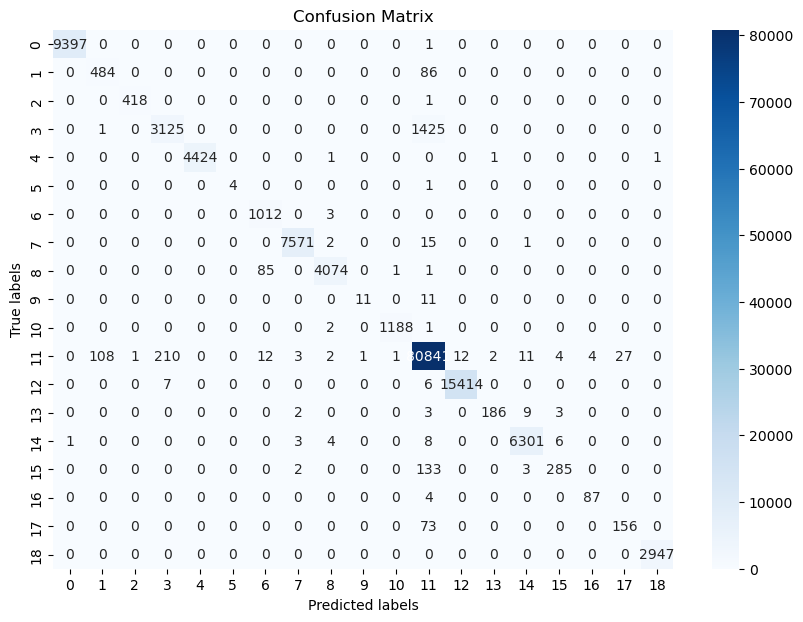

In [32]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

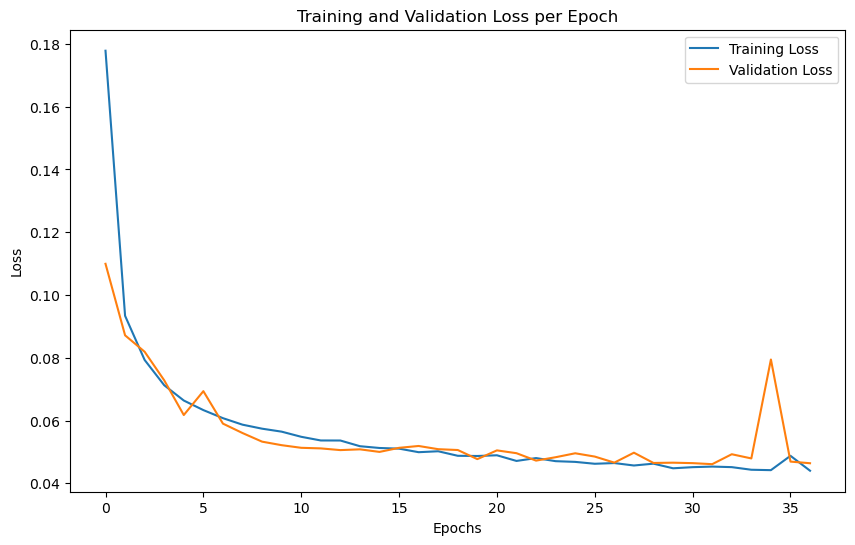

In [33]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Metrics (No Attacks)

### Helpers

In [13]:
def calculate_weighted_rates(cm):
    num_classes = cm.shape[0]
    total_instances = np.sum(cm)
    
    weighted_TPR = 0
    weighted_TNR = 0
    weighted_FPR = 0
    weighted_FNR = 0
    
    for class_index in range(num_classes):
        TP = cm[class_index, class_index]
        FP = cm[:, class_index].sum() - TP
        FN = cm[class_index, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        
        class_size = cm[class_index, :].sum()  # Total true instances for the class
        
        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        TNR = TN / (TN + FP) if (TN + FP) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        FNR = FN / (FN + TP) if (FN + TP) != 0 else 0
        
        weighted_TPR += (class_size / total_instances) * TPR
        weighted_TNR += (class_size / total_instances) * TNR
        weighted_FPR += (class_size / total_instances) * FPR
        weighted_FNR += (class_size / total_instances) * FNR

    return weighted_TPR, weighted_TNR, weighted_FPR, weighted_FNR

def metrics_weighted(model, test_load, num_classes, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    probabilities = np.array(probabilities)

    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(labels_binarized, probabilities, average='weighted', multi_class='ovr')

    cm = confusion_matrix(all_labels, all_preds)
    
    TPR, TNR, FPR, FNR = calculate_weighted_rates(cm)

    print(f'Accuracy (Weighted): {accuracy:.4f}')
    print(f'Precision (Weighted): {precision:.4f}')
    print(f'Recall (Weighted): {recall:.4f}')
    print(f'F1 Score (Weighted): {f1:.4f}')
    print(f'AUC (Weighted): {auc:.4f}')
    print(f'TPR (Weighted): {TPR:.4f}')
    print(f'TNR (Weighted): {TNR:.4f}')
    print(f'FPR (Weighted): {FPR:.4f}')
    print(f'FNR (Weighted): {FNR:.4f}')

In [14]:
def calculate_class_metrics_macro(cm, class_index):
    TP = cm[class_index, class_index]
    FP = cm[:, class_index].sum() - TP
    FN = cm[class_index, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0  
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0  
    
    return TPR, TNR, FPR, FNR

def metrics_macro(model, test_load, num_classes, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    probabilities = np.array(probabilities)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), probabilities, average='macro', multi_class='ovr')

    cm = confusion_matrix(all_labels, all_preds)

    # Calculate metrics for each class and take the average
    metrics = np.array([calculate_class_metrics_macro(cm, i) for i in range(num_classes)])
    TPR_macro, TNR_macro, FPR_macro, FNR_macro = np.mean(metrics, axis=0)

    print(f'Accuracy (Macro): {accuracy:.4f}')
    print(f'Precision (Macro): {precision:.4f}')
    print(f'Recall (Macro): {recall:.4f}')
    print(f'F1 Score (Macro): {f1:.4f}')
    print(f'AUC (Macro): {auc:.4f}')
    print(f'TPR (Macro): {TPR_macro:.4f}')
    print(f'TNR (Macro): {TNR_macro:.4f}')
    print(f'FPR (Macro): {FPR_macro:.4f}')
    print(f'FNR (Macro): {FNR_macro:.4f}')

In [15]:
def calculate_metrics_micro(cm):
    TP_sum = np.sum(np.diag(cm))  # Sum of True Positives
    FP_sum = np.sum(cm) - TP_sum  # Sum of False Positives (total minus TP)
    FN_sum = FP_sum  # In micro-averaging for multi-class, FN and FP are equivalent in sum
    TN_sum = np.sum(cm) * (cm.shape[0] - 1) - 2 * FP_sum  # Adjusting TN for multi-class
    
    TPR_micro = TP_sum / (TP_sum + FN_sum) if (TP_sum + FN_sum) != 0 else 0
    TNR_micro = TN_sum / (TN_sum + FP_sum) if (TN_sum + FP_sum) != 0 else 0
    FPR_micro = FP_sum / (FP_sum + TN_sum) if (FP_sum + TN_sum) != 0 else 0
    FNR_micro = FN_sum / (FN_sum + TP_sum) if (FN_sum + TP_sum) != 0 else 0
    
    return TPR_micro, TNR_micro, FPR_micro, FNR_micro

def metrics_micro(model, test_load, num_classes, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    probabilities = np.array(probabilities)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')
    auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), probabilities, average='micro', multi_class='ovr')

    cm = confusion_matrix(all_labels, all_preds)
    TPR_micro, TNR_micro, FPR_micro, FNR_micro = calculate_metrics_micro(cm)

    print(f'Accuracy (Micro): {accuracy:.4f}')
    print(f'Precision (Micro): {precision:.4f}')
    print(f'Recall (Micro): {recall:.4f}')
    print(f'F1 Score (Micro): {f1:.4f}')
    print(f'AUC (Micro): {auc:.4f}')
    print(f'TPR (Micro): {TPR_micro:.4f}')
    print(f'TNR (Micro): {TNR_micro:.4f}')
    print(f'FPR (Micro): {FPR_micro:.4f}')
    print(f'FNR (Micro): {FNR_micro:.4f}')


## Evaluations

In [34]:
metrics_weighted(model_dnn, test_loader, 19, device)

Accuracy (Weighted): 0.9836
Precision (Weighted): 0.9832
Recall (Weighted): 0.9836
F1 Score (Weighted): 0.9826
AUC (Weighted): 0.9989
TPR (Weighted): 0.9836
TNR (Weighted): 0.9825
FPR (Weighted): 0.0175
FNR (Weighted): 0.0164


In [35]:
metrics_macro(model_dnn, test_loader, 19, device)

Accuracy (Macro): 0.9836
Precision (Macro): 0.9629
Recall (Macro): 0.8959
F1 Score (Macro): 0.9226
AUC (Macro): 0.9991
TPR (Macro): 0.8959
TNR (Macro): 0.9982
FPR (Macro): 0.0018
FNR (Macro): 0.1041


In [36]:
metrics_micro(model_dnn, test_loader, 19, device)

Accuracy (Micro): 0.9836
Precision (Micro): 0.9836
Recall (Micro): 0.9836
F1 Score (Micro): 0.9836
AUC (Micro): 0.9999
TPR (Micro): 0.9836
TNR (Micro): 0.9991
FPR (Micro): 0.0009
FNR (Micro): 0.0164
